In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostRegressor

from scipy import stats

sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/julienjta/Data-Science-Portfolio/main/Project%201/data/dataset.csv",index_col=0)
print("There are {} observations for {} predictors.".format(df.shape[0],df.shape[1]))
df.head()

There are 300153 observations for 11 predictors.


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [3]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

There are no missing values.

In [4]:
df.describe(include='all')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000
unique,6,1561,6,6,3,6,6,2,NaN,NaN,NaN
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000


<AxesSubplot:xlabel='price'>

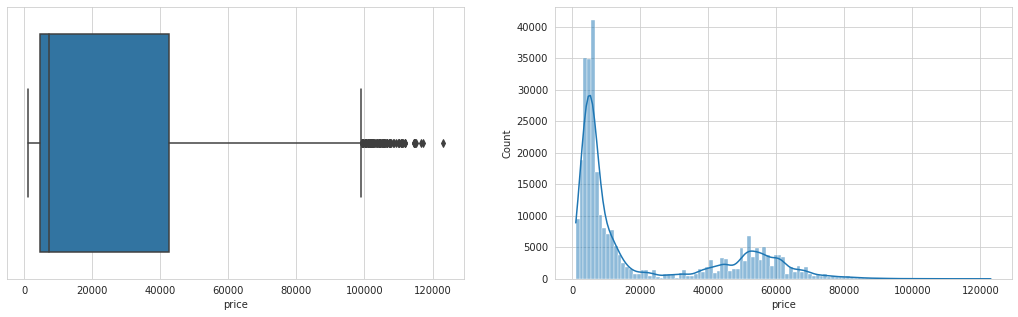

In [5]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,2)
sns.histplot(x = 'price', data = df, kde = True)
plt.subplot(1,2,1)
sns.boxplot(x = 'price', data = df)

Even though the mean is around 20000, we can see here that the median is approximately 7500. This difference is explainable by the presence of two different tickets: business and economy. On the second graph, we can see that the dispersion seems to be composed by two gaussian curves.

---

### How does the ticket price vary between Economy and Business class?

To visualize the difference between the two kind of tickets, I will plot the prices for the two prices for both business and economy tickets for the different companies.

Text(0.5, 1.0, 'Airline prices based on the class and company')

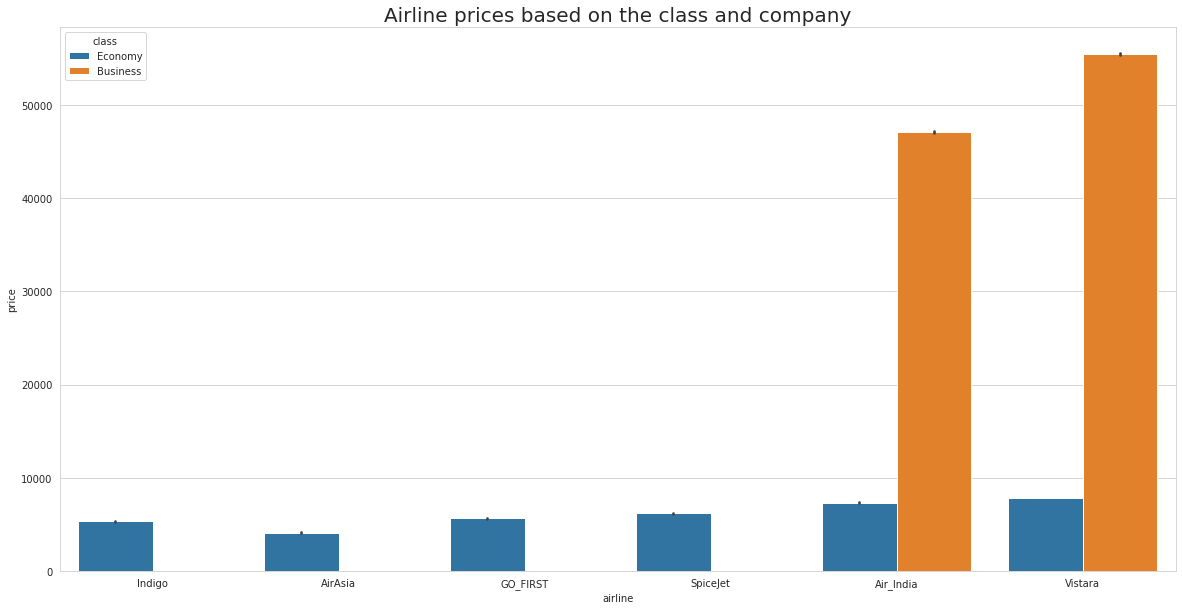

In [6]:
plt.figure(figsize=(20, 10))
sns.barplot(x='airline',y='price',hue="class",data=df.sort_values("price")).set_title('Airline prices based on the class and company',fontsize=20)

> 📌 Business flights are only available in two companies: Air India and Vistara. Also, there is a big gap between the prices in the two class that reaches almost 5 times the price of Economy for Business tickets.

---

### Does price vary with Airlines?

To compare the prices between the companies we will only compare the same kind of tickets since the previous question showed that the class has a big impact on the final price.

Text(0.5, 1.0, 'Airline prices based on companies for business tickets')

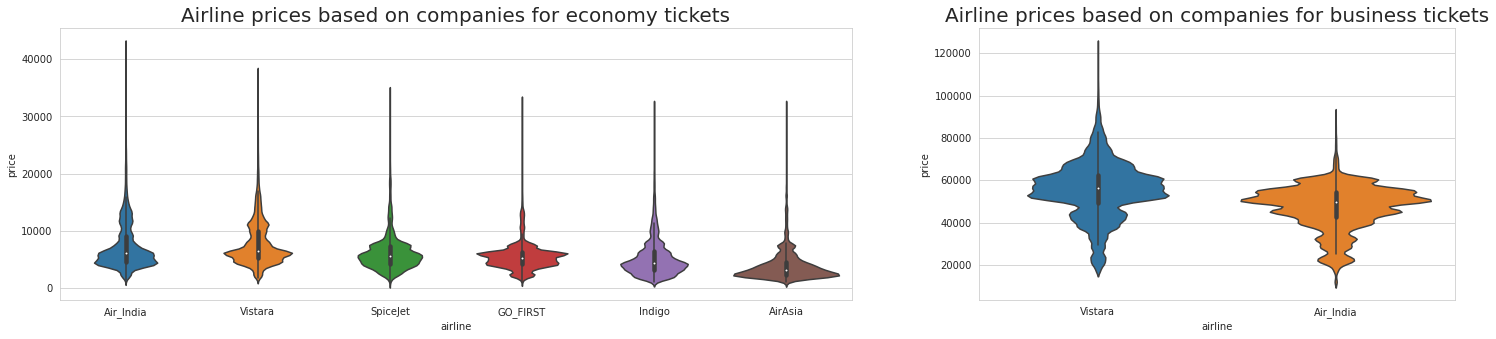

In [7]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))
sns.violinplot(y = "price", x = "airline",data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False), kind="boxen", ax=axs[0])
axs[0].set_title("Airline prices based on companies for economy tickets",fontsize=20)
sns.violinplot(y = "price", x = "airline",data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False), kind="boxen", ax=axs[1])
axs[1].set_title("Airline prices based on companies for business tickets",fontsize=20)

> 📌 There are slight differences between each companies on this graph, AirAsia seems to have the cheapest flights when Air India and Vistara are more expensive. However it looks like Vistara's business tickets are a little more expensive than the Air India's ones.

---

### How is the price affected when tickets are bought in just 1 or 2 days before departure?

To visualize how the prices changes depending on the number of days left, I will calculate the average price depending on the days left, to try to understand a pattern in the curve.

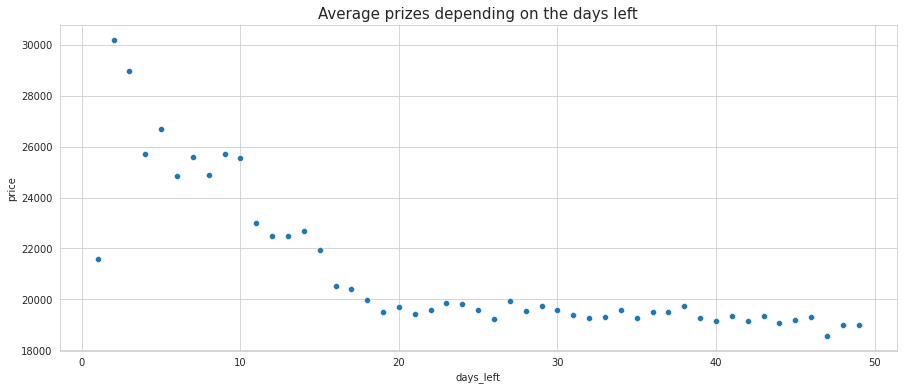

In [8]:
df_temp = df.groupby(['days_left'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="days_left", y="price", data=df_temp).set_title("Average prizes depending on the days left",fontsize=15)

It is possible to see two different curves on this graph, the first one, stable between 50 and 20 days before the flight, and a positive monotone curve between 20 and 2 days before.

<AxesSubplot:xlabel='days_left', ylabel='price'>

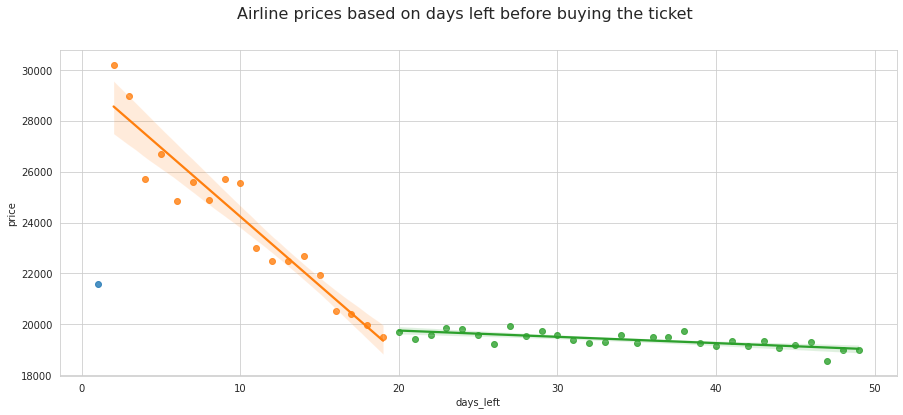

In [9]:
plt.figure(figsize=(15,6)).suptitle('Airline prices based on days left before buying the ticket', fontsize=16)
ax = plt.axes()
sns.regplot(x=df_temp.loc[df_temp["days_left"]==1].days_left, y=df_temp.loc[df_temp["days_left"]==1].price, fit_reg=False, ax=ax)
sns.regplot(x=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].days_left, y=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].price, fit_reg=True, ax=ax)
sns.regplot(x=df_temp.loc[df_temp["days_left"]>=20].days_left, y=df_temp.loc[df_temp["days_left"]>=20].price, fit_reg=True, ax=ax)

A pattern is clearly visible in the way prices evolve depending on the days left.

> 📌 The graph highlights how the prices rise slowly and then drastically start rising 20 days before the flight, but fall just one day before the flight up to three times cheaper. This can be explain by the fact the companies want to fill their empty seats and thus lower the prices of the tickets to ensure the planes remains full.

---

### Does the price change with the duration of the flight?

Let's see how the duration of the flight may affect the final price.

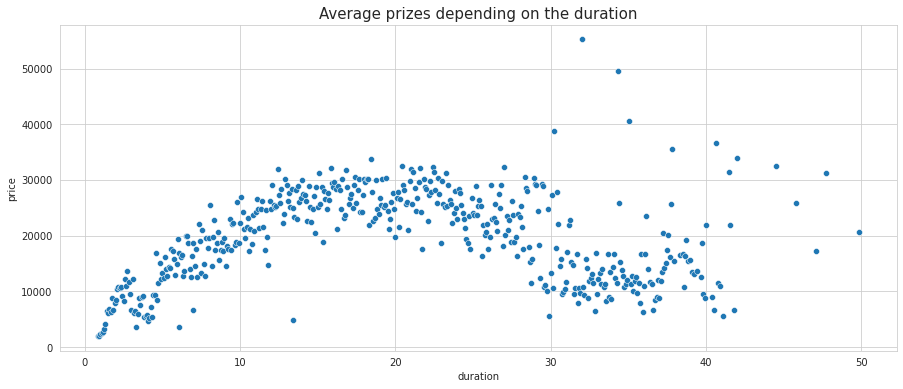

In [10]:
df_temp = df.groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)

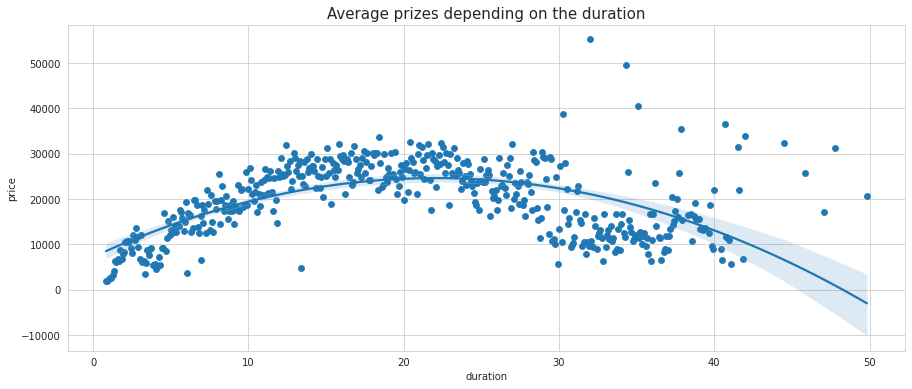

In [11]:
plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)
ax = sns.regplot(x="duration", y="price", data=df_temp, order=2)

> 📌 It is clear that here the relationship is not linear but can be approximated with a second degree curve. The prices reaches a high price at a duration of 20 hours before lowering again.
>
> However some outliers seem to affect the regression curve .

---

### Does ticket price change based on the departure time and arrival time?

Text(0.5, 1.0, 'Airline prices based on the arrival time')

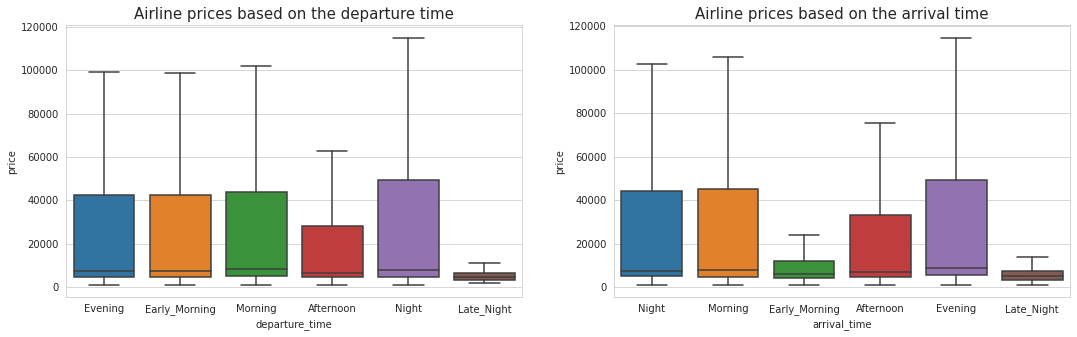

In [12]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.boxplot(data=df, y="price", x="departure_time",showfliers=False).set_title("Airline prices based on the departure time",fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(data=df, y="price", x="arrival_time",showfliers=False).set_title("Airline prices based on the arrival time",fontsize=15)

> 📌 As expected, leaving at night or arriving at night remains the cheapest way to travel. But it's also visible that arriving early morning is also cheap and afternoon flight are a bit cheaper that evening, morning and night flight.

---

### How the price changes with change in Source and Destination?

To answer this question, I will visualize the different prices for all the destinations as a departure and arrival destination.

Text(0.5, 0.98, 'Airline prices based on the source and destination cities')

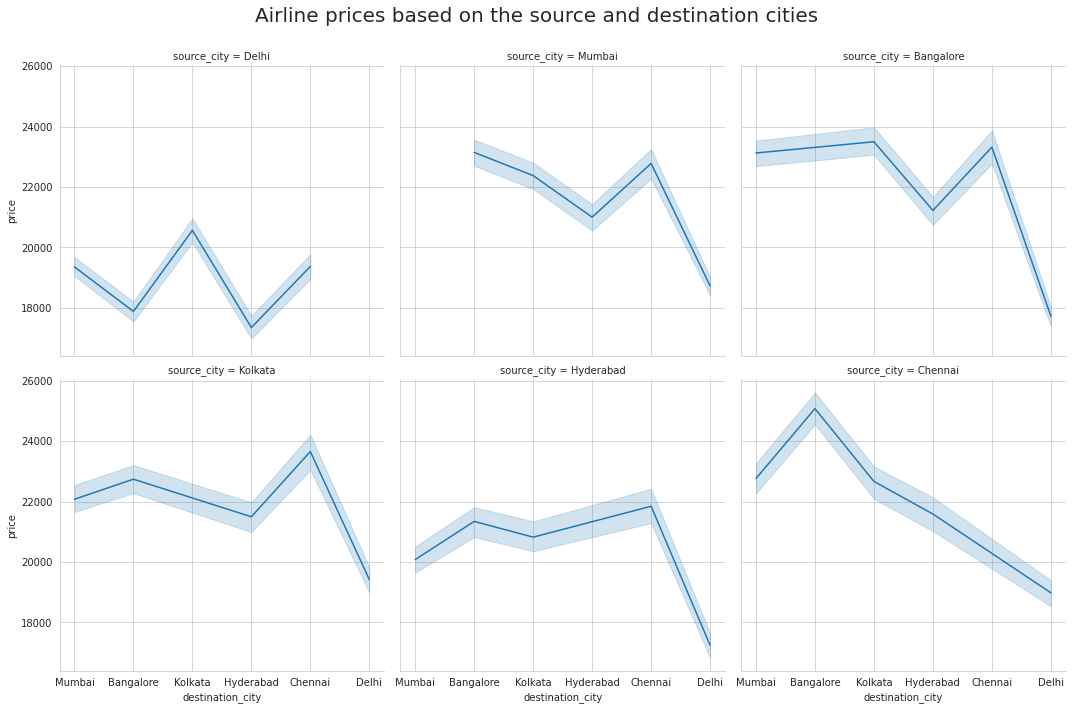

In [13]:
ax = sns.relplot(col="source_city", y="price", kind="line",x='destination_city', data=df, col_wrap=3)
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle('Airline prices based on the source and destination cities',fontsize=20)

> 📌 On one hand, it seems that flight leaving from Delhi are often cheaper that from other source cities and the capital is also the cheapest deatination to go probably because as a capital cities, the airport is the biggest and proposes more flights. In an other hand, the prices are more or less similar and Hyderabad being the most expensive destination.

---

### Does the number of stops influences the price?

Let's see how the number of stop may influence the final price.

Text(0.5, 1.0, 'Airline prices based on the number of stops  for business')

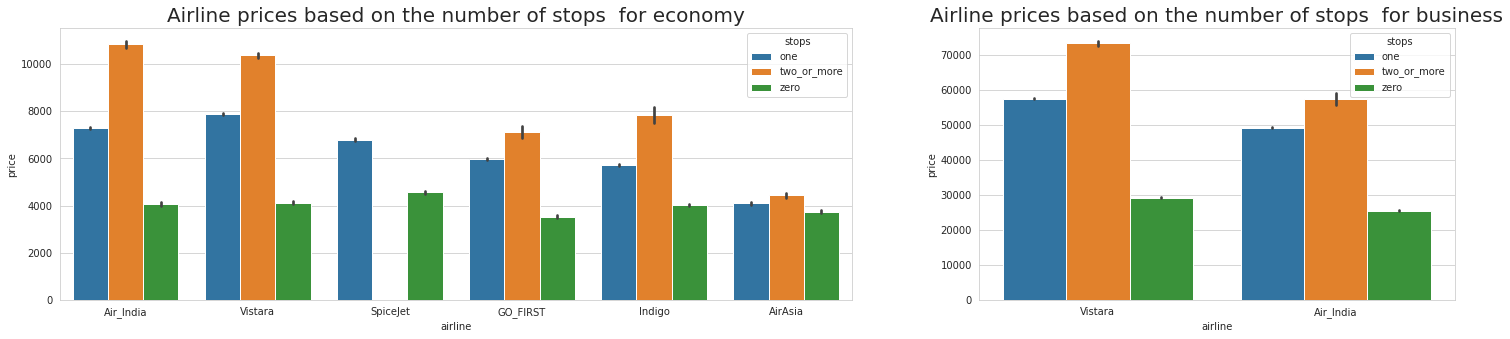

In [14]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))
sns.barplot(y = "price", x = "airline",hue="stops",data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False), ax=axs[0])
axs[0].set_title("Airline prices based on the number of stops  for economy",fontsize=20)
sns.barplot(y = "price", x = "airline",hue="stops",data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False), ax=axs[1])
axs[1].set_title("Airline prices based on the number of stops  for business",fontsize=20)

> 📌 It's clear that the more stops there are the more expensive the flight is except for AirAsia where the prices seems more constant. The behaviour and different analysis of AirAsia tend to show that it relates to a low cost company.

---

### What variables influence most the price?

In [15]:
def preprocessing(df):
    #Encode the ordinal variables "stops" and "class".
    df["stops"] = df["stops"].replace({'zero':0,'one':1,'two_or_more':2}).astype(int)
    df["class"] = df["class"].replace({'Economy':0,'Business':1}).astype(int)
    
    #Create the dummy variables for the cities, the times and the airlines.
    dummies_variables = ["airline","source_city","destination_city","departure_time","arrival_time"]
    dummies = pd.get_dummies(df[dummies_variables], drop_first= True)
    df = pd.concat([df,dummies],axis=1)
    
    #Create the dummy variables for the cities, the times and the airlines.
    df = df.drop(["flight","airline","source_city","destination_city","departure_time","arrival_time"],axis=1)
    
    return df

In [16]:
df_preprocessed = preprocessing(df)

To visualize the linear importance of each variables on the target, I will plot a correlation matrix.

<AxesSubplot:>

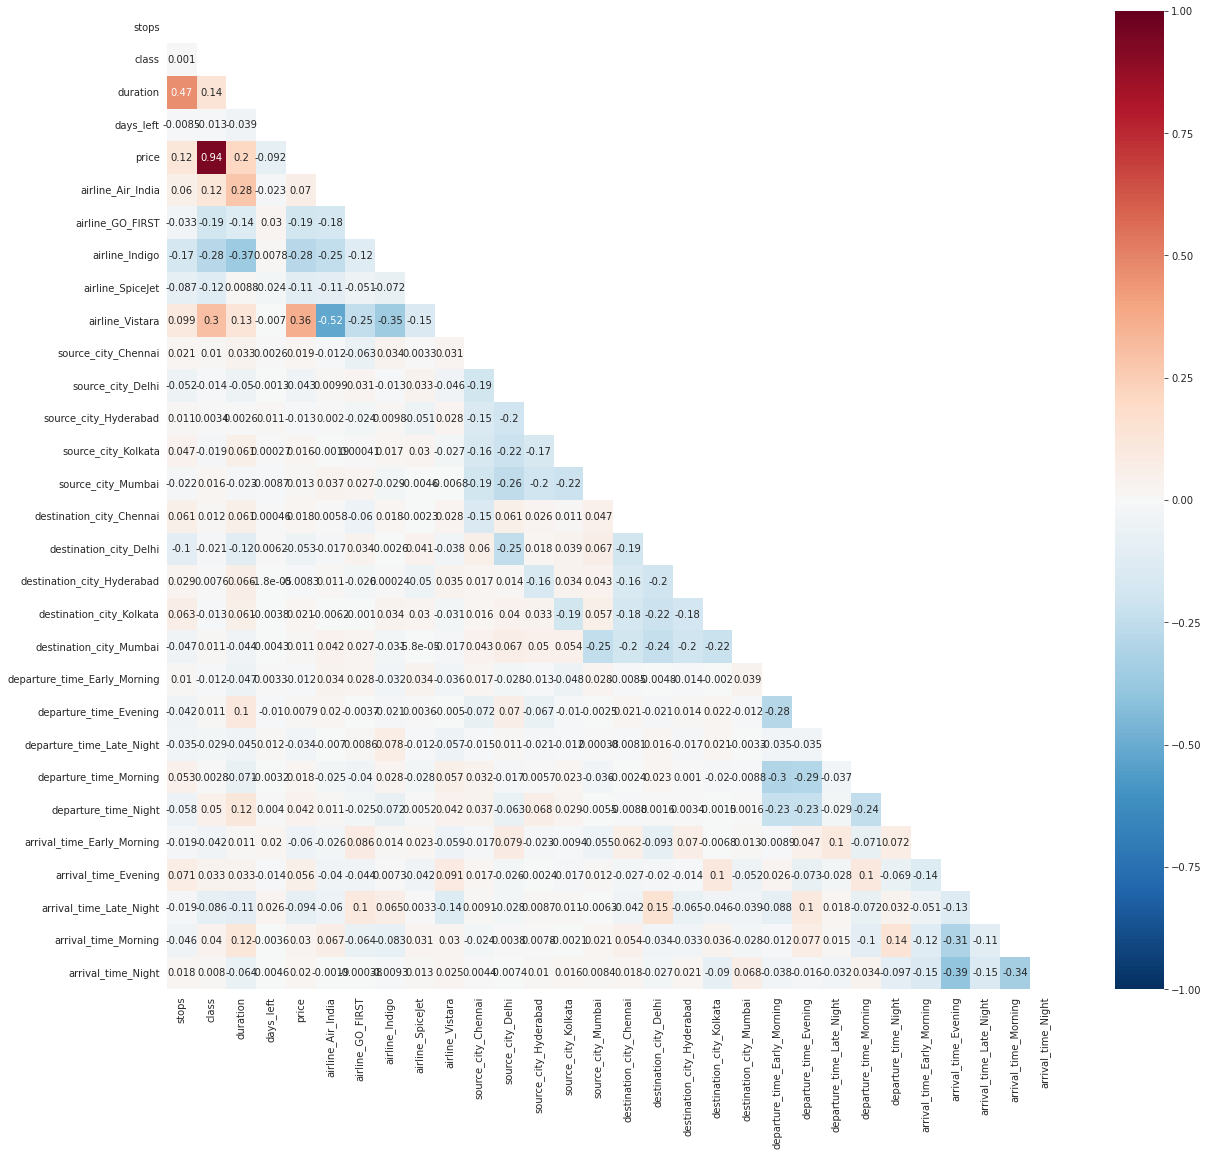

In [17]:
mask = np.triu(np.ones_like(df_preprocessed.corr(), dtype=bool))

plt.figure(figsize = (20,18))
sns.heatmap(df_preprocessed.corr(), data = df_preprocessed, mask=mask,annot = True, vmin= -1.0, vmax= 1.0, center = 0, cmap = 'RdBu_r')

However, the correlation is a good metric for linear relationship, but doesn't highlight non linear ones. For that I will use mutual information.

In [18]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [19]:
X = df_preprocessed.copy()
y = X.pop("price")

mi_scores = make_mi_scores(X, y)

In [20]:
print(mi_scores.sort_values(ascending=False))

duration                        2.416936
class                           0.618061
airline_Vistara                 0.516296
days_left                       0.477366
source_city_Delhi               0.431156
source_city_Mumbai              0.429834
airline_Air_India               0.403201
stops                           0.393255
destination_city_Delhi          0.387879
destination_city_Mumbai         0.382828
source_city_Kolkata             0.361059
source_city_Hyderabad           0.347045
destination_city_Kolkata        0.339032
source_city_Chennai             0.326053
destination_city_Hyderabad      0.321119
destination_city_Chennai        0.303286
airline_Indigo                  0.288444
airline_GO_FIRST                0.202520
arrival_time_Evening            0.126667
arrival_time_Night              0.107493
departure_time_Evening          0.104264
arrival_time_Morning            0.098781
departure_time_Morning          0.093396
departure_time_Early_Morning    0.086883
airline_SpiceJet

>📌 This importance analysis shows us the class or the fast that the flight is a Vistara one but vairables like the duration of the flight or the number of days left have strong non linear relationship too as we saw on the previous questions.

---

## 📊 Prediction of the flight price
In this part, I will try to find the best model to predict the flight price with the given dataset.

### Load the data

In [21]:
def load_data():
    # Read data
    df = pd.read_csv("https://raw.githubusercontent.com/julienjta/Data-Science-Portfolio/main/Project%201/data/dataset.csv",index_col=0)
    # Preprocessing the data
    
    df = preprocessing(df)
    
    X = df.copy()
    y = X.pop("price")
    
    xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state = 1,test_size=0.3, shuffle=True)
    
    return xtrain,xtest,ytrain,ytest

In [22]:
xtrain,xtest,ytrain,ytest = load_data()

### Define the best model

In [23]:
models = {}

models["KNeighborsRegressor"]={"model":KNeighborsRegressor(n_neighbors=50)}
models["LinearRegression"]={"model":LinearRegression()}
models["XGBRegressor"]={"model":XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=1)}
models["CatBoostRegressor"]={"model":CatBoostRegressor(logging_level ='Silent',iterations=500,random_state=1)}

In [24]:
def score_dataset(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    score_r2 = cross_val_score(model, X, y, cv=5, scoring="r2")
    score_r2 = score_r2.mean()
    
    return score_r2

In [25]:
 def get_scores(models,xtrain,ytrain):
    for name,model in models.items():
        model["model"].fit(xtrain,ytrain)

        score_r2 = score_dataset(xtrain, ytrain, model=model["model"])
        score = {'model':"Linear regression", 'score_r2':score_r2}
        print("--- "+name+" ---")
        print("Score r2: {}".format(score_r2))
        print("\n")

In [26]:
get_scores(models,xtrain,ytrain)

--- KNeighborsRegressor ---
Score r2: 0.7091119883657736


--- LinearRegression ---
Score r2: 0.9095338142489373


--- XGBRegressor ---
Score r2: 0.9821663952532429


--- CatBoostRegressor ---
Score r2: 0.9734375563075298




It seems that best results are given by the XGBRegressor. This may be explain by the fact the some relationships ar enot linear like the duration or the days_left. Thus a more flexible algorithm like XGBRegressor tends to give better results.

### Apply the model on the test dataset

Let's now compute the score for the test dataset.

In [27]:
model = models["XGBRegressor"]["model"]
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)

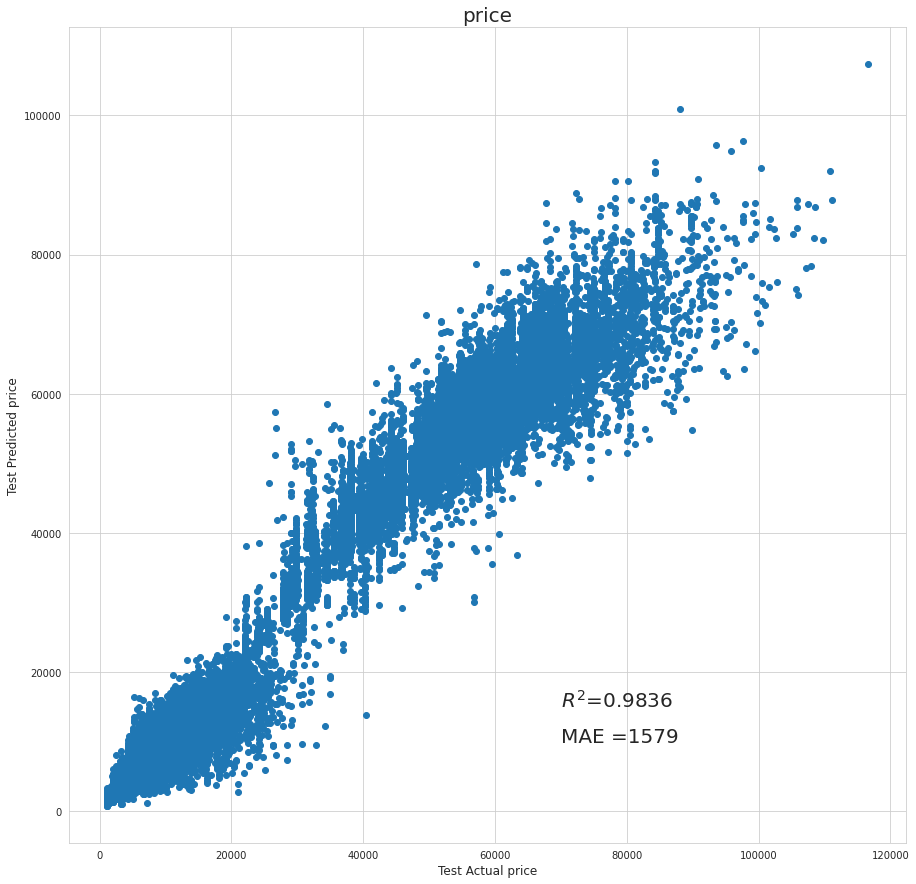

In [28]:
fig,ax = plt.subplots(figsize=(15,15))
ax.set_title("price",fontsize=20)
ax.set_ylabel('Test Predicted price',fontsize=12)
ax.set_xlabel('Test Actual price',fontsize=12)
ax.scatter(ytest,ypred)

score_r2 = r2_score(ytest, ypred) 
score_mae = mean_absolute_error(ytest, ypred)
plt.text(70000,15000,'$ R^{2} $=' + str(round(score_r2, 4)),fontsize=20)
plt.text(70000,10000,'MAE =' + str(round(score_mae)),fontsize=20)
plt.show()

And now I will use the **stacking and blending** technique to improve the score.

The first layers will composed with all the different regressor functions. And the final layer will be XGBRegressor since it gave the best results.

In [29]:
def stackblend_reg(x_train,y_train,x_test,models,code,N=20,final_layer=LinearRegression()):
    
    def get_dataset(x_train,y_train,N=5) :
        merge = pd.concat([x_train,y_train],axis=1)
        merge = merge.sample(frac=1, random_state=1).reset_index(drop=True)
        y_train = merge.iloc[:,(merge.shape[1]-1):(merge.shape[1])]
        x_train = merge.iloc[:,0:(merge.shape[1]-1)]

        z = int(len(x_train)/N)
        start = [0]
        stop = []
        for i in range(1,N):
            start.append(z*i)
            stop.append(z*i)
        stop.append(len(x_train))

        c = list()
        train_data = list()
        test_data = list()
        y_data = list()
        for i in range(0,N):
            c=list(range(start[i],stop[i]))
            train_data.append(x_train.iloc[[k for k in range(0,len(x_train)) if k not in c],:])
            y_data.append(y_train.iloc[[k for k in range(0,len(y_train)) if k not in c],:])
            test_data.append(x_train.iloc[c,:])

        return(train_data,y_data,test_data,y_train)
    
    datasets = get_dataset(x_train,y_train,N)
    train_data = datasets[0]
    y_data = datasets[1]
    test_data = datasets[2]
    final_y =  datasets[3]
    
    def stack(x_train, y_train , x_test , models=models,code=code):
    
        def flatten_list(_2d_list):
            flat_list = []
            for element in _2d_list:
                if type(element) is list:
                    for item in element:
                        flat_list.append(item)
                else:
                    flat_list.append(element)
            return flat_list

        result = list()
        for i in list(range(len(models))):
            reg = models[i]
            reg.fit(x_train,y_train)
            test_pred = flatten_list(reg.predict(x_test).tolist())
            result.append(test_pred)

        result_df = pd.DataFrame()    
        for i in list(range(len(code))):
            result_df[code[i]] = result[i]
        return result_df
    final_df = pd.DataFrame(columns = code)
    
    for i in range(0,len(train_data)):
        current_df = stack(train_data[i],y_data[i],test_data[i],models,code)
        final_df = pd.concat([final_df,current_df])
        
    final_test = stack(x_train,y_train,x_test,models,code)
    
    reg2 = final_layer
    reg2.fit(final_df,final_y)
    test_pred = reg2.predict(final_test)
    
    return test_pred

In [30]:
stack_pred = stackblend_reg(xtrain,ytrain,xtest,
                            models = [XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=1),
                                      LinearRegression(),
                                    KNeighborsRegressor(n_neighbors=50),
                                     CatBoostRegressor(logging_level ='Silent',iterations=500,random_state=1)],
                            code = ['xgb_reg','lin_reg','knn_reg','cat_reg'],N=10,
                            final_layer=XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=1))

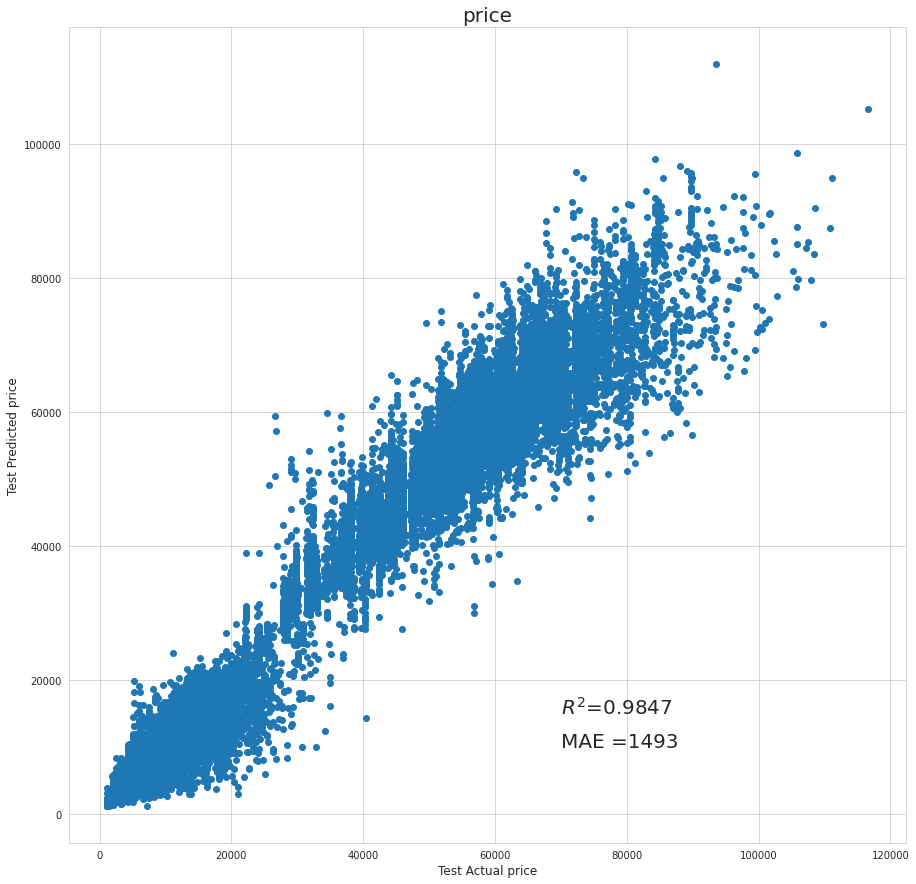

In [31]:
score_r2 = r2_score(ytest, stack_pred) 
score_mae = mean_absolute_error(ytest, stack_pred)
fig,ax = plt.subplots(figsize=(15,15))
ax.set_title("price",fontsize=20)
ax.set_ylabel('Test Predicted price',fontsize=12)
ax.set_xlabel('Test Actual price',fontsize=12)
ax.scatter(ytest,stack_pred)

score_r2 = r2_score(ytest, stack_pred) 
score_mae = mean_absolute_error(ytest, stack_pred)
plt.text(70000,15000,'$ R^{2} $=' + str(round(score_r2, 4)),fontsize=20)
plt.text(70000,10000,'MAE =' + str(round(score_mae)),fontsize=20)
plt.show()

## Take away points

>**1.** The model that gives the best result is the XGBRegressor with on the test dataset an R^2 score equals to 0.9836 and a MAE score equals to 1579. However when we use the stacking and bending method, we can reduce the MAE by more than 5% with 1493 and increase the R^2 score to 0.9847.
>
>**2.** There is a big gap between flight tickets in business and economy. In average business tickets are 6.5 times more expensive than economy tickets.
>
>**3.** Vistara and AirIndia seems to be the most expensive companies and AirAsia the cheapest. However for business tickets, only Vistara  and AirIndia are available, and Vistara is slightly more expensive.
>
>**4.** In general, prices rise quite slowly until 20 days before the flight where the prices rise drastically. But one day before the flight, there usually are empty seats that have not been sold. Thus it is possible to find tickets three times cheaper than the day before.
>
>**5.** The longer the flight is the more expensive the tickets are until it reaches around 20 hours, then the prices tend to decrease.
>
>**6.** For the time of the flight:
 >- It seems that departure during the afternoon and late night are cheaper, and night more expensive.
 >- It seems that departure during the early morning, afternoon and late night are cheaper, and evening more expensive.
 >
>**7.** For the cities of the trip:
    >- Flights from Delhi are the cheapest the from the others cities seems equal on average but slightly more expensive for Chenai.
    >- Flight to Delhi are the cheapest and to Bengalore the most expensive ones.
>
>**8.** In general, the more stops there are, the more expensive the flight ticket is.